In [8]:
import json
import os
import numpy
import pandas
import pyarrow
import sys

from datetime import date
from os import path
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Steps to install
# 1. pip install sqlalchemy-bigquery google-cloud-bigquery-storage pyarrow
# 2. Copy the credentials file to wherever you set BIGQUERY_CREDENTIALS_PATH to

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

In [2]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
import create_queries
%load_ext autoreload
%autoreload 2

In [3]:
COMPANY_NAME = 'RA'
COMPANY_IDENTIFIER = 'RA'
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'
INVENTORY_DATES = [
    '01/31/2020',
    '02/28/2020',
    '03/31/2020',
    '04/30/2020',
    '05/31/2020',
    '06/30/2020',
    '07/31/2020',
    '08/31/2020',
    '09/30/2020',
    '10/31/2020',
    '11/30/2020',
    '12/31/2020',
    '01/31/2021',
    '02/28/2021',
    '03/31/2021',
    '04/30/2021',
    '05/31/2021',
    '06/30/2021',
    '07/31/2021',
    '08/31/2021',
    '09/30/2021',
]
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0
}
TODAY_DATE = date.today().strftime('%m/%d/%Y')
INVENTORY_DATES.append(TODAY_DATE)
print('Today is {}'.format(TODAY_DATE))

Today is 11/01/2021


In [4]:
# Download packages, sales transactions, incoming / outgoing tranfers

company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(COMPANY_IDENTIFIER)

company_incoming_transfer_packages_dataframe = pandas.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pandas.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_sales_transactions_dataframe = pandas.read_sql_query(company_sales_transactions_query, engine)
company_inventory_packages_dataframe = pandas.read_sql_query(company_inventory_packages_query, engine)

In [6]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts/analysis")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

from util import active_inventory_util as util

In [12]:
d = util.Download()
d.download_dataframes(
    incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
    outgoing_transfer_packages_dataframe=company_outgoing_transfer_packages_dataframe,
    sales_transactions_dataframe=company_sales_transactions_dataframe,
    engine=engine,
)

In [16]:
q = util.Query()
q.inventory_dates = INVENTORY_DATES
q.company_name = COMPANY_NAME

id_to_history = util.get_histories(d)
util.print_counts(id_to_history)

Only outgoing: 7
Only incoming: 1581
Only sold: 0
In and out: 37
In and sold at least once 4205
In and sold many times 4068
Total pkgs: 5806


In [20]:
import math

import importlib
importlib.reload(util)

date_to_inventory_packages_dataframe = {}
id_to_history = util.get_histories(d)

inventory_valuations = []

for inventory_date in INVENTORY_DATES:
    print(inventory_date)
    
    computed_inventory_package_records = util.create_inventory_dataframe_by_date(
        id_to_history, inventory_date, params=ANALYSIS_PARAMS)    
    computed_inventory_packages_dataframe = pandas.DataFrame(
        computed_inventory_package_records,
        columns=util.get_inventory_column_names(),
    )
    date_to_inventory_packages_dataframe[inventory_date] = computed_inventory_packages_dataframe
    in_inventory_computed_inventory_packages_dataframe = computed_inventory_packages_dataframe[computed_inventory_packages_dataframe['is_in_inventory'] == 'true']
    
    print(f'# packages in inventory: {len(in_inventory_computed_inventory_packages_dataframe.index)}')
    
    inventory_with_incoming_transfer_packages_dataframe = in_inventory_computed_inventory_packages_dataframe \
        .astype({'package_id': 'int64'}) \
        .merge(
            company_incoming_transfer_packages_dataframe.astype({'package_id': 'int64'}),
            on='package_id',
            how='inner',
            suffixes=('_l', '_r')
        )

    inventory_with_cost_records = inventory_with_incoming_transfer_packages_dataframe.to_dict('record')

    total_valuation_cost = 0

    for inventory_with_cost_record in inventory_with_cost_records:
        incoming_shipped_price = inventory_with_cost_record['shipper_wholesale_price']
        if math.isnan(incoming_shipped_price):
            incoming_shipped_price = 0
        incoming_shipped_quantity = inventory_with_cost_record['shipped_quantity']
        current_quantity = inventory_with_cost_record['quantity']
        total_valuation_cost += float(current_quantity) * (incoming_shipped_price / incoming_shipped_quantity)
    
    print(f'$ valuation of inventory: {total_valuation_cost}')
    print('')
    
    inventory_valuations += [total_valuation_cost]

01/31/2020
# packages in inventory: 0
$ valuation of inventory: 0

02/28/2020
# packages in inventory: 46
$ valuation of inventory: 2478.8496045197735

03/31/2020
# packages in inventory: 230
$ valuation of inventory: 25827.89276419717

04/30/2020
# packages in inventory: 546
$ valuation of inventory: 57450.98082941316

05/31/2020
# packages in inventory: 720
$ valuation of inventory: 53243.7757484291

06/30/2020
# packages in inventory: 889
$ valuation of inventory: 53071.83812988744

07/31/2020
# packages in inventory: 1048
$ valuation of inventory: 69668.59659548789

08/31/2020
# packages in inventory: 1319
$ valuation of inventory: 111217.69815247356

09/30/2020
# packages in inventory: 1537
$ valuation of inventory: 146117.560307431

10/31/2020
# packages in inventory: 1802
$ valuation of inventory: 186346.34521140804

11/30/2020
# packages in inventory: 1815
$ valuation of inventory: 141868.17218673232

12/31/2020
# packages in inventory: 1926
$ valuation of inventory: 128358.620

In [25]:
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)

engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

company_sales_receipts_dataframe = pandas.read_sql_query(company_sales_receipts_query, engine)

In [26]:
fn = lambda row: f'{row.sales_datetime.year}-{"0" if row.sales_datetime.month < 10 else ""}{row.sales_datetime.month}'
col = company_sales_receipts_dataframe.apply(fn, axis=1)
company_sales_receipts_dataframe = company_sales_receipts_dataframe.assign(sales_month=col.values)

In [27]:
# company_sales_receipts_dataframe.groupby(['sales_month'])['total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)
gmv_by_month_dataframe = company_sales_receipts_dataframe.groupby(['sales_month'])['total_price'].sum()
gmv_by_month_dataframe

sales_month
2020-03     33886.44
2020-04     88659.34
2020-05    135380.48
2020-06    148263.48
2020-07    174943.68
2020-08    186034.10
2020-09    199931.81
2020-10    207834.38
2020-11    200319.70
2020-12    220334.99
2021-01    216208.37
2021-02    189439.27
2021-03    212136.22
2021-04    238124.90
2021-05    248644.73
2021-06    220601.48
2021-07    219837.94
2021-08    214533.51
2021-09    180901.27
2021-10    181787.15
2021-11      5361.39
Name: total_price, dtype: float64

In [28]:
list(gmv_by_month_dataframe.array)

[33886.439999999966,
 88659.33999999978,
 135380.48,
 148263.47999999986,
 174943.6799999999,
 186034.10000000027,
 199931.81,
 207834.3800000001,
 200319.69999999978,
 220334.98999999976,
 216208.37,
 189439.27000000022,
 212136.21999999997,
 238124.90000000005,
 248644.7299999998,
 220601.4799999999,
 219837.94000000015,
 214533.50999999992,
 180901.26999999958,
 181787.14999999976,
 5361.3899999999985]

In [31]:
# Super hacky left pad of array with None values such that array lengths match up.
len(INVENTORY_DATES), len(inventory_valuations), len([None] + list(gmv_by_month_dataframe.array))

(22, 22, 22)

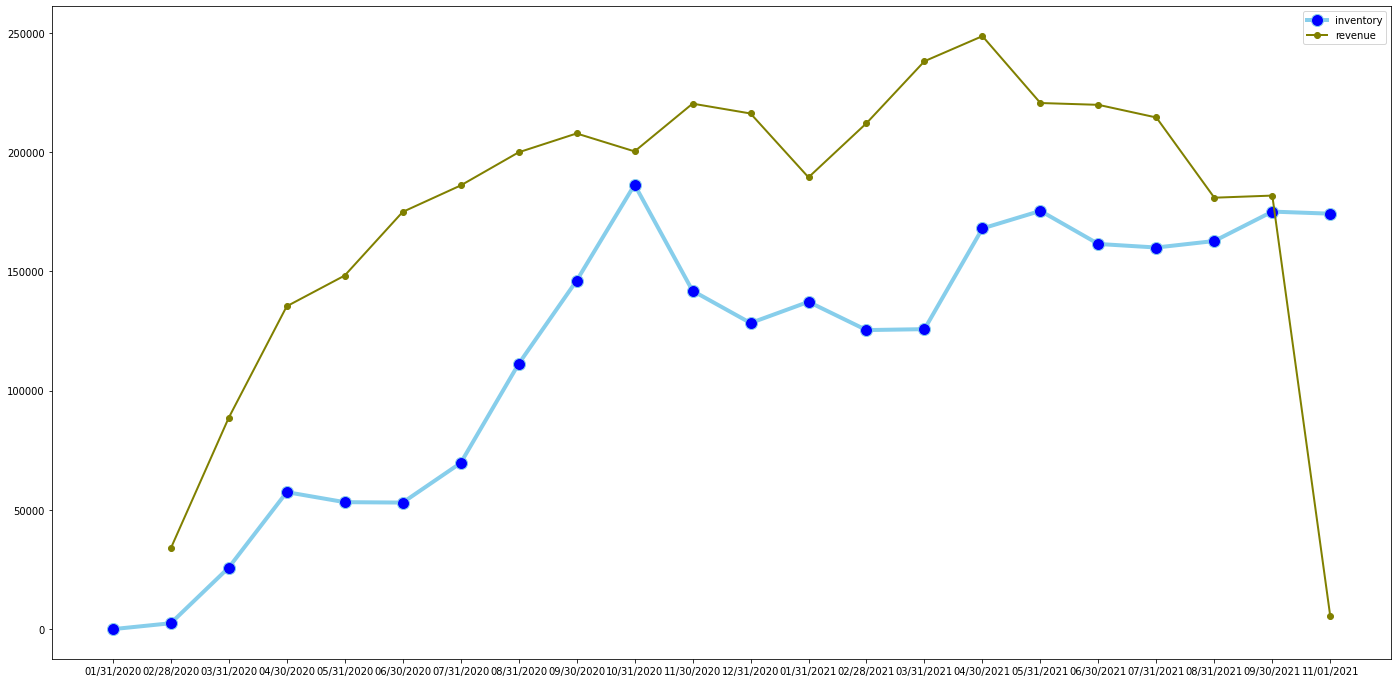

In [32]:
import matplotlib.pyplot as plt

df = pandas.DataFrame({
    'x_values': INVENTORY_DATES,
    'inventory': inventory_valuations,
    'revenue': [None] + list(gmv_by_month_dataframe.array),
})
 
# multiple line plots
plt.figure(figsize=(24, 12))
plt.plot( 'x_values', 'inventory', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x_values', 'revenue', data=df, marker='o', color='olive', linewidth=2)

# show legend
plt.legend()

# show graph
plt.show()